<a href="https://www.kaggle.com/code/mustafadagteki/sql-analyzing-students-mental-health?scriptVersionId=157051848" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

## Analyzing Students Mental Health

Does going to university in a different country affect your mental health? A Japanese international university surveyed its students in 2018 and published a study the following year that was approved by several ethical and regulatory boards.

The study found that international students have a higher risk of mental health difficulties than the general population, and that social connectedness (belonging to a social group) and acculturative stress (stress associated with joining a new culture) are predictive of depression.


Explore the `students` data using PostgreSQL to find out if you would come to a similar conclusion for international students and see if the length of stay is a contributing factor.

Here is a data description of the columns you may find helpful.

| Field Name    | Description                                      |
| ------------- | ------------------------------------------------ |
| `inter_dom`     | Types of students (international or domestic)   |
| `japanese_cate` | Japanese language proficiency                    |
| `english_cate`  | English language proficiency                     |
| `academic`      | Current academic level (undergraduate or graduate) |
| `age`           | Current age of student                           |
| `stay`          | Current length of stay in years                  |
| `todep`         | Total score of depression (PHQ-9 test)           |
| `tosc`          | Total score of social connectedness (SCS test)   |
| `toas`          | Total score of acculturative stress (ASISS test) |

In [1]:
pip install duckdb


  Obtaining dependency information for duckdb from https://files.pythonhosted.org/packages/7c/d5/7688cdc1b57c9ada17b6f6143a923606294b462e4b15e3ac249c04649bde/duckdb-0.9.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 50.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import necessary libraries
# We will use duckdb for sql queries
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import duckdb

In [3]:
# load data
students = pd.read_csv("/kaggle/input/portfolio-projects-data/students.csv")

In [4]:
query1 = """SELECT * 
            FROM students
            LIMIT 5;"""
result1 = duckdb.query(query1).to_df()
result1

,inter_dom,region,gender,academic,age,age_cate,stay,stay_cate,japanese,japanese_cate,...,friends_bi,parents_bi,relative_bi,professional_bi,phone_bi,doctor_bi,religion_bi,alone_bi,others_bi,internet_bi
0,Inter,SEA,Male,Grad,24.0,4.0,5.0,Long,3.0,Average,...,Yes,Yes,No,No,No,No,No,No,No,No
1,Inter,SEA,Male,Grad,28.0,5.0,1.0,Short,4.0,High,...,Yes,Yes,No,No,No,No,No,No,No,No
2,Inter,SEA,Male,Grad,25.0,4.0,6.0,Long,4.0,High,...,No,No,No,No,No,No,No,No,No,No
3,Inter,EA,Female,Grad,29.0,5.0,1.0,Short,2.0,Low,...,Yes,Yes,Yes,Yes,No,No,No,No,No,No
4,Inter,EA,Female,Grad,28.0,5.0,1.0,Short,1.0,Low,...,Yes,Yes,No,Yes,No,Yes,Yes,No,No,No


In [5]:
query2 = """
		/* Checking for multiple null values */
		SELECT COUNT(*)
		FROM students
		WHERE inter_dom IS NULL
			AND region IS NULL
			AND GENDER IS NULL
			AND academic IS NULL;"""
result2 = duckdb.query(query2).to_df()
result2

,count_star()
0,18


In [6]:
# /* Find the distribution of students by Region, Gender and Academic */
query3 = """WITH region_total AS (
                SELECT 
                    region,
                    COUNT(*) AS Total_by_Region
                FROM students
                WHERE region IS NOT NULL AND gender IS NOT NULL AND academic IS NOT NULL
                GROUP BY region
            ),
            global_total AS (
                SELECT 
                    COUNT(*) AS Total_Global
                FROM students
                WHERE region IS NOT NULL AND gender IS NOT NULL AND academic IS NOT NULL
            )
            SELECT 
                s.region,
                CASE
                    WHEN (s.gender IS NULL AND s.academic IS NULL) THEN 'Total for Region'
                    WHEN (s.region IS NULL AND s.gender IS NULL AND s.academic IS NULL) THEN 'Global Total'
                    ELSE s.gender
                END AS gender,
                CASE 
                    WHEN s.academic IS NULL THEN 'All Academics'
                    ELSE s.academic 
                END AS academic,
                COUNT(*) AS Total_Students,
                ROUND(COUNT(*) * 100.0 / r.Total_by_Region, 2) AS Percentage_by_Region,
                ROUND(COUNT(*) * 100.0 / g.Total_Global, 2) AS Global_Percentage
            FROM students s
            JOIN region_total r ON s.region = r.region
            CROSS JOIN global_total g
            WHERE s.region IS NOT NULL AND s.gender IS NOT NULL AND s.academic IS NOT NULL
            GROUP BY ROLLUP (s.region, s.gender, s.academic), r.Total_by_Region, g.Total_Global
            ORDER BY s.region, s.gender, s.academic
            LIMIT 10;"""
result3 = duckdb.query(query3).to_df()
result3


,region,gender,academic,Total_Students,Percentage_by_Region,Global_Percentage
0,EA,Female,Grad,3,6.25,1.12
1,EA,Female,Under,21,43.75,7.84
2,EA,Female,All Academics,24,50.00,8.96
3,EA,Male,Grad,1,2.08,0.37
4,EA,Male,Under,23,47.92,8.58
5,EA,Male,All Academics,24,50.00,8.96
6,EA,Total for Region,All Academics,48,100.00,17.91
7,JAP,Female,Grad,1,1.45,0.37
8,JAP,Female,Under,42,60.87,15.67
9,JAP,Female,All Academics,43,62.32,16.04


In [7]:
query4 ="""/* Find the distribution of International and domestic students */
		SELECT 
			CASE
				WHEN inter_dom = 'Dom' THEN 'Domestic'
				WHEN inter_dom = 'Inter' THEN 'International' END AS origin,
			gender,
			COUNT(gender) AS no_of_students,
			ROUND(AVG(age),2) AS avg_age,
			ROUND(AVG(stay),2) AS avg_stay_year,
			ROUND(AVG(japanese),2) AS avg_japanese_lang,
			ROUND(AVG(english),2) AS avg_english_lang	
		FROM students
		WHERE inter_dom IS NOT NULL
		GROUP BY ROLLUP (inter_dom, gender)
		ORDER BY 1,2;"""

result4 = duckdb.query(query4).to_df()
result4

,origin,gender,no_of_students,avg_age,avg_stay_year,avg_japanese_lang,avg_english_lang
0,Domestic,Female,42,20.36,2.31,4.90,2.88
1,Domestic,Male,25,20.48,2.56,4.68,2.96
2,Domestic,None,67,20.40,2.40,4.82,2.91
3,International,Female,128,20.79,1.98,2.45,3.87
4,International,Male,73,21.45,2.22,2.64,3.95
5,International,None,201,21.03,2.06,2.52,3.90
6,None,None,268,20.87,2.15,3.10,3.65


In [8]:
query5 ="""/* Find the distribution of International and domestic students */
			SELECT 
				CASE
					WHEN inter_dom = 'Dom' THEN 'Domestic'
					WHEN inter_dom = 'Inter' THEN 'International' END AS origin,
				gender,
				COUNT(gender) AS no_of_students,
				ROUND(AVG(todep),2) AS avg_score_of_depression,
				ROUND(AVG(tosc),2) AS avg_score_of_social_connect,
				ROUND(AVG(toas),2) AS avg_score_of_acculturative_stress
			FROM students
			WHERE inter_dom IS NOT NULL
			GROUP BY ROLLUP (inter_dom, gender)
			ORDER BY 1,2;"""
   
result5 = duckdb.query(query5).to_df()
result5

,origin,gender,no_of_students,avg_score_of_depression,avg_score_of_social_connect,avg_score_of_acculturative_stress
0,Domestic,Female,42,8.50,37.45,62.45
1,Domestic,Male,25,8.80,37.96,63.48
2,Domestic,None,67,8.61,37.64,62.84
3,International,Female,128,8.37,36.93,78.20
4,International,Male,73,7.48,38.27,70.95
5,International,None,201,8.04,37.42,75.56
6,None,None,268,8.19,37.47,72.38


In [9]:
query6 = """/* Find the average scores by length of stay for international students, and view them in descending order */
               SELECT 
               stay,
               ROUND(AVG(todep), 2) AS average_phq, 
               ROUND(AVG(tosc), 2) AS average_scs, 
               ROUND(AVG(toas), 2) AS average_as
               FROM students
               WHERE inter_dom = 'Inter'
               GROUP BY stay
               ORDER BY stay DESC;"""

result6 = duckdb.query(query6).to_df()
result6

,stay,average_phq,average_scs,average_as
0,10.0,13.00,32.00,50.00
1,8.0,10.00,44.00,65.00
2,7.0,4.00,48.00,45.00
3,6.0,6.00,38.00,58.67
4,5.0,0.00,34.00,91.00
5,4.0,8.57,33.93,87.71
6,3.0,9.09,37.13,78.00
7,2.0,8.28,37.08,77.67
8,1.0,7.48,38.11,72.80


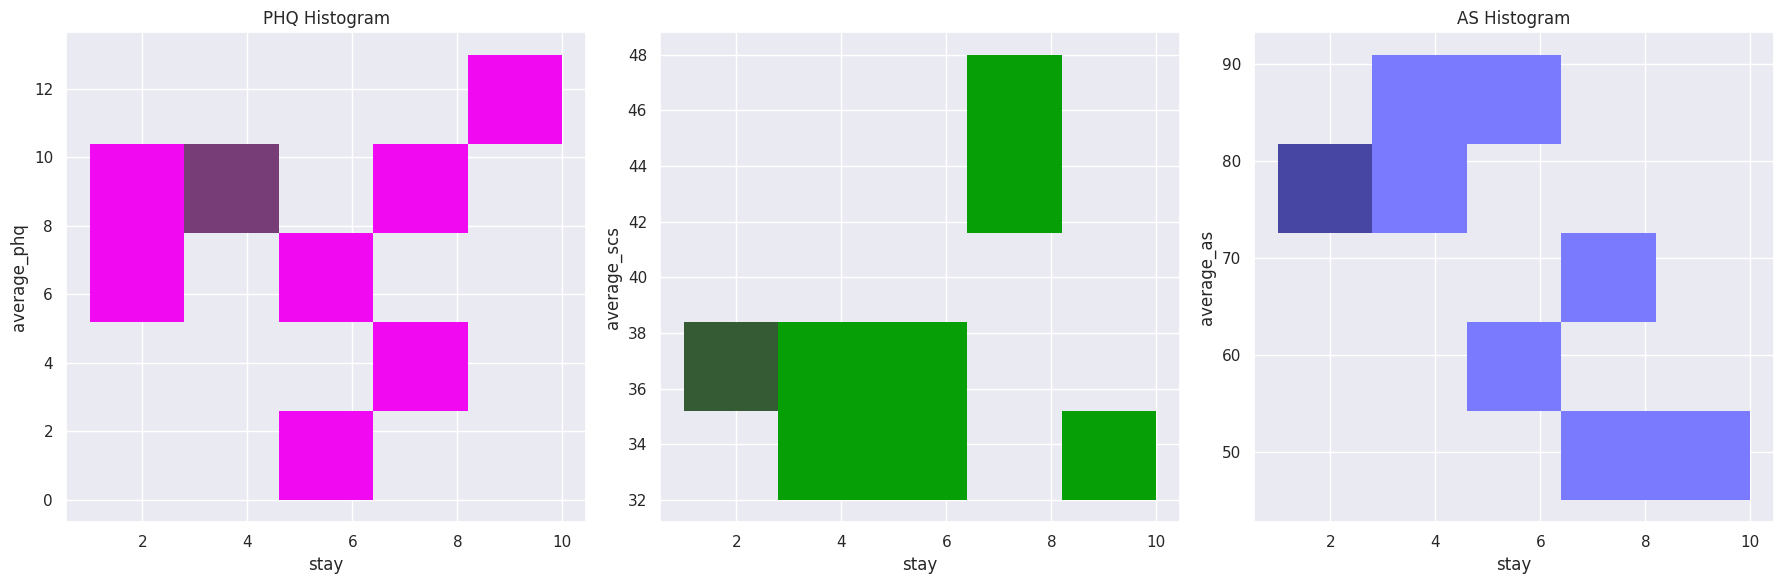

In [10]:
sns.set()
fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 
sns.histplot(data=result6, x="stay", y="average_phq",color='purple', ax=axs[0])
axs[0].set_title('PHQ Histogram')
sns.histplot(data=result6, x="stay", y="average_scs",color='green', ax=axs[1])
axs[0].set_title('PHQ Histogram')
sns.histplot(data=result6, x="stay", y="average_as",color='blue', ax=axs[2])
axs[2].set_title('AS Histogram')
plt.tight_layout()
plt.show()

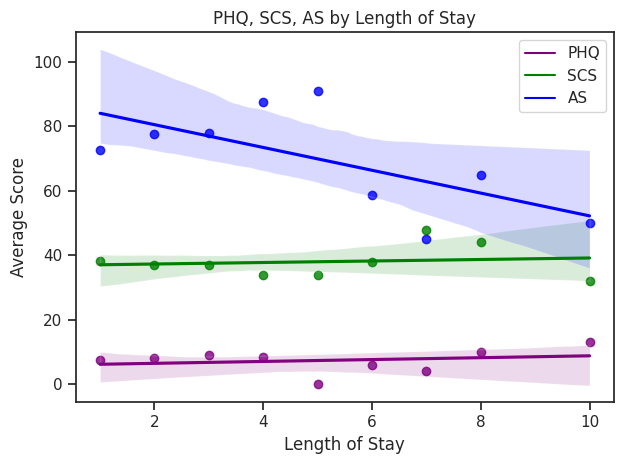

In [11]:
sns.set(style="ticks")
sns.regplot(data=result6, x="stay", y="average_phq", color='purple')
sns.regplot(data=result6, x="stay", y="average_scs", color='green')
sns.regplot(data=result6, x="stay", y="average_as", color='blue')
legend_handles = [mlines.Line2D([], [], color='purple', label='PHQ'),
                  mlines.Line2D([], [], color='green', label='SCS'),
                  mlines.Line2D([], [], color='blue', label='AS')]
plt.legend(handles=legend_handles, loc='upper right')
plt.xlabel('Length of Stay')
plt.ylabel('Average Score')
plt.title('PHQ, SCS, AS by Length of Stay')
plt.tight_layout()
plt.show()